# Finance Time Series Inference

Like in Stepanov et al., try to model the time series of the mean correlation value c_bar. We use their proposed shape for the multiplicative noise 

D_2 = L² * ( (c_bar - c_min)* (c_max - c_bar) ). Probably should use a prior c_min < c_bar < c_max.

Like Stepanov suspects, we introduce a time dependence in D_1 via the following trick:
Feed the data as 2d time series (x1, x2) with x2 = c_bar and x1 = t. Manually set dx1/dt = 1 (i.e. all coefficients for dx1/dt in the minimisation function).

In [1]:
import numpy as np
import matplotlib.pylab as plt
import time
from scipy import optimize
# from numba import jit
import pandas as pd

np.random.seed(1234)

n_noise = 3 # number of noise parameters: L, c_min, c_max

In [2]:
## Define all the functions

#@jit
def poly(x,sigma):
    x_vec=np.array([1,x[0],x[1],x[0]*x[0],x[1]*x[0],
                    x[1]*x[1],x[0]*x[0]*x[0],x[1]*x[0]*x[0],x[1]*x[1]*x[0],x[1]*x[1]*x[1],
                   x[0]**4, x[0]**3 * x[1], x[0]**2 * x[1]**2, x[0]*x[1]**3, x[1]**4],
                    dtype=object)
    return np.dot(sigma,x_vec)



#@jit
def D1(sigma,x):
    # Make use of the fact that here, x_1 = t and hence dx_1/dt = 1
    sigma_d1 = sigma[n_noise:] # without noise parameters
    return poly(x.T, sigma_d1)


#@jit
def D2(alpha,x):
    return alpha[0]**2. *( (x[:,1]  - alpha[1]) * (alpha[2] - x[:,1]) )
    

#  Log Likelihood and negative logL

def log_likelihood(alpha,x,dt):
    # alpha is the current set of parameters
    # x is the entire data set N x 2
    # dt is the time difference
    
    log_like = 0 # initial value of sum
    
    #calculate D1 and D2 or each position in the data x
    
    minx = min(x[:,1])
    maxx = max(x[:,1])
    
    if alpha[0]>0 and  alpha[1] > 0. and alpha[1] < minx and alpha[2] > maxx : # noise must be positive and c_min < c_bar < c_max
        
        dx = x[1:,:]-x[:-1,:]  
        
        # only the x[:,1] component is the actual time series
        d1 = dx[:,1] - D1(alpha,x)[:-1]*dt
        d2 = D2(alpha,x)[:-1]
        d2_inv = d2**(-1.)
        log_like = ( -0.5*np.log(d2) - 0.5 * d2_inv * d1**2.).sum()
        
        return log_like
    else:
        return -np.inf


def neg_log_likelihood(alpha,x,dt): #L Threshold Lambdac
    return -1*log_likelihood(alpha,x,dt)


# NEVER cut off all noise terms!
def cutIndex(Parameters, Threshold):
    Index = (np.abs(Parameters) < Threshold)
    Index[0:n_noise] = False
    return(Index)

def second_neg_log_likelihood(Coeff, Index,x,dt):
    # Index: Index of those coefficients which are set to 0: Boolean 
    Index = cutIndex(Coeff,L_thresh)
    Coeff[Index] = 0
    return -1*log_likelihood(Coeff,x,dt)


# BIC as goodness criterion for a threshold value

def BIC(alpha,x,dt,L): # mit Lambda Threshold
    
    logi = np.abs(alpha)>L # which are larger than Lambda?
    logi[0:n_noise] = True  # noise is always included
    return np.log(x[:,0].size)*np.sum(  logi ) - 2*log_likelihood(alpha, x,dt )


# Calculate BIC in the Loop with thresholding

def Loop(x, dt, L, a_Ini):
    # estimates alpha parameters based on starting values a_Ini for a given threshold L
    a_hat = optimize.minimize(neg_log_likelihood, a_Ini,args=(x,dt)) # max likelihood
    Estimation = a_hat["x"]
    Estimation[n_noise:] =  Estimation[n_noise:] * ( abs(Estimation[n_noise:] ) > L ) 
    
    for i in np.arange(0,n_Cut):
        Cut = (np.abs(Estimation)<L) # Boolean of the values that are cut off
        # second optimization with maxLikelEstimator as start:
        a_hat = optimize.minimize(second_neg_log_likelihood,Estimation,args = (Cut,x,dt))
        Estimation = a_hat["x"]
        Estimation[n_noise:] =  Estimation[n_noise:] * ( abs(Estimation[n_noise:] ) > L )
    return(Estimation)




(5251, 2)
           t     c_bar
0      0.000  0.100816
1      0.004  0.098629
2      0.008  0.095379
3      0.012  0.093081
4      0.016  0.092683
...      ...       ...
5246  20.984  0.299250
5247  20.988  0.305746
5248  20.992  0.317696
5249  20.996  0.322748
5250  21.000  0.338906

[5251 rows x 2 columns]


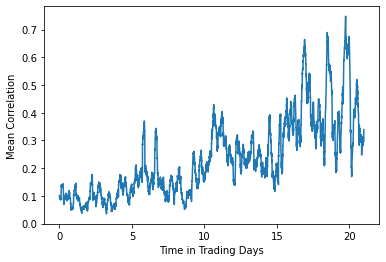

In [3]:
#Get Data
filename = 'TimeSeries_Finance_Reduced'    # 2D data x1, x2
x = pd.read_csv(filename, header = 0, index_col = 0)
dt = 1/250  # 250 trading days are a trading year
print(x.shape)
x["t"] = dt * np.arange(0,x.shape[0],1) # time index should not be datetime
print(x)
x = x.to_numpy()
plt.plot(x[:,0], x[:,1])
plt.xlabel("Time in Trading Days")
plt.ylabel("Mean Correlation")
plt.show()

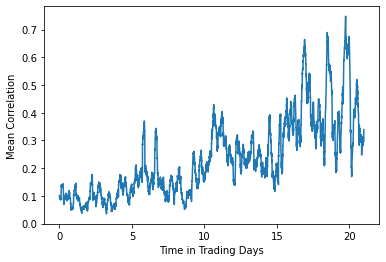

In [4]:
plt.plot(x[:,0], x[:,1])
plt.xlabel("Time in Trading Days")
plt.ylabel("Mean Correlation")
plt.savefig("FinanceData")
plt.show()

In [5]:
dx = x[1:]-x[:-1]  
Lambda = 0.5 # initial threshold

N = x[:,0].size

In [6]:
# Set up variables for the hyperparameter search on threshold

n_Cut = 5 # Number of reiterating
hp1 = np.arange(0.00,1.5, 0.1) # list of possible thresholds
n_Iteration = len(hp1) # Number of Hyperparameter search iterations
score = np.empty(n_Iteration) # score for Hyperparameters


# In[5]:

In [7]:
TestAl = np.ones(18)   # sample parameters to start the search

#Starting values for noise range:
TestAl[0] = 1./np.sqrt(6.) # roughly taken from the Stepanov paper but scaled to trading years instead of days
TestAl[1] = 0.9 * min(x[:,1])
TestAl[2] = 1.5 * max(x[:,1])
print(TestAl)

# initial guess for drift coefficients: least squares
def Diff_D1(Coefficients,x,dt):
    dx = x[1:]-x[:-1] 
    D1 = poly(x.T,Coefficients)[:-1]
    return(sum((dx[:,1]-D1)**2.))
TestLS = optimize.minimize(Diff_D1,np.ones(15),args=(x,dt)) 
TestAl[3:] = TestLS["x"]

AlphaList = np.empty((n_Iteration, TestAl.size)) # store the results of each optimization here 

real = np.ones(18) # we don't know the real parameters and hence print out everything

 
# to show the important terms
output = (real!=0) #relevant terms



TestAl = optimize.minimize(neg_log_likelihood,TestAl,args=(x,dt)) 
# first estimation with maybe less than full data

TestAl = TestAl["x"]

print(TestAl)

[0.40824829 0.03120007 1.12236204 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.        ]


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 6.33062537e-02  3.46667267e-02  7.51797592e-01  4.06082758e-01
  2.51091169e-01  7.36902324e-01 -9.63595812e-02 -4.76244661e-01
  3.12974726e+01  2.23727887e-03 -8.17759232e-01  2.70023186e+01
 -4.23726874e+02 -2.66533472e-05  5.28530325e-02 -1.16838016e+00
  5.49732827e-01  2.48986018e+02]


In [8]:



for i in range(n_Iteration):
    L_thresh = hp1[i]
    estimate = Loop(x, dt, hp1[i], TestAl)
    AlphaList[i,:] = estimate
    score[i] = BIC(estimate, x, dt, hp1[i])
    print(estimate[output])
    print(hp1[i], score[i])


np.savetxt('Alpha_Done.txt',AlphaList)
d = {'Threshold': hp1, 'BIC': score}
df = pd.DataFrame(data=d)
print(df)
df.to_csv("Score_BIC.csv")



C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 1.18634510e-02  2.97949174e-02  3.55458581e+00  1.30801126e-01
 -9.51862757e-03  2.95498436e+00 -1.87111944e-02  2.03585195e+00
 -9.33072784e+01  3.76660481e-04  1.52845681e-01 -1.43844225e+01
  4.41621544e+02 -1.05193500e-05 -1.33513515e-03 -1.38193432e-01
  1.75002496e+01 -4.93781936e+02]
0.0 -44644.592925092125


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 4.16340681e-02  2.93657796e-02  8.63682654e-01 -2.85724324e-01
 -0.00000000e+00  2.86073932e+00 -0.00000000e+00  2.61381959e+00
 -9.32762470e+01  0.00000000e+00 -1.00211122e-01 -1.34241176e+01
  4.41608711e+02 -0.00000000e+00 -0.00000000e+00  1.44525320e-01
  1.72316832e+01 -4.93820324e+02]
0.1 -40876.126929915124


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 1.82051461e-02  2.14226729e-02  1.53593658e+00  0.00000000e+00
 -0.00000000e+00  2.99478645e+00 -0.00000000e+00  3.98912063e-01
 -4.73442291e+01  0.00000000e+00  0.00000000e+00 -8.37987630e-01
  1.24983585e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -2.18227588e-01 -7.56231059e+01]
0.2 -44796.953922182394


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.24488030e-02  2.39737059e-02  1.11313936e+00  0.00000000e+00
 -0.00000000e+00  5.27970603e+00 -0.00000000e+00  4.16128685e-01
 -7.29241904e+01  0.00000000e+00  0.00000000e+00 -3.08558028e-01
  1.83309942e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -1.62690660e+00 -9.72175796e+01]
0.30000000000000004 -44786.82601476351


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 1.71422473e-02  2.12074852e-02  1.69656841e+00  0.00000000e+00
 -0.00000000e+00  3.76398039e+00 -0.00000000e+00  4.85418797e-01
 -6.15806305e+01  0.00000000e+00  0.00000000e+00 -1.06978262e+00
  1.72918531e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
 -4.26294201e-01 -1.07933688e+02]
0.4 -44794.38474822375


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 1.90836843e-02  2.23003765e-02  1.42725975e+00  0.00000000e+00
 -0.00000000e+00  3.54613617e+00 -0.00000000e+00  5.00127652e-01
 -5.88121850e+01  0.00000000e+00  0.00000000e+00 -1.24471045e+00
  1.66576040e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.09546925e+02]
0.5 -44804.40108059224


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.27867140e-02  2.41173681e-02  1.09218396e+00  0.00000000e+00
 -0.00000000e+00  5.29059992e+00 -0.00000000e+00  6.01343665e-01
 -7.93210624e+01  0.00000000e+00  0.00000000e+00 -1.49218720e+00
  2.22529305e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  0.00000000e+00 -1.49685201e+02]
0.6000000000000001 -44792.27809334143


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.34470451e-02  2.44726150e-02  1.04897383e+00  0.00000000e+00
 -0.00000000e+00  5.51256109e+00 -0.00000000e+00  7.16800525e-01
 -8.78642376e+01  0.00000000e+00  0.00000000e+00 -2.10946940e+00
  2.60843777e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  7.00649795e-01 -1.89772449e+02]
0.7000000000000001 -44777.14754619497


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.28237966e-02  2.42102237e-02  1.08558483e+00  0.00000000e+00
 -0.00000000e+00  5.49420571e+00 -0.00000000e+00  8.00184637e-01
 -9.20289296e+01  0.00000000e+00  0.00000000e+00 -2.61946105e+00
  2.83612891e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  1.39260157e+00 -2.17757722e+02]
0.8 -44776.08887479495


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.23899144e-02  2.40113792e-02  1.11879544e+00  0.00000000e+00
 -0.00000000e+00  5.42783883e+00 -0.00000000e+00  9.00003261e-01
 -9.59356106e+01  0.00000000e+00  0.00000000e+00 -3.26487732e+00
  3.08758839e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  2.26706897e+00 -2.50507811e+02]
0.9 -44773.31466204813


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.30360240e-02  2.42961970e-02  1.07708372e+00  0.00000000e+00
 -0.00000000e+00  5.38295587e+00 -0.00000000e+00  1.00057952e+00
 -9.88775595e+01  0.00000000e+00  0.00000000e+00 -3.89176281e+00
  3.28815226e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  3.10846012e+00 -2.77650208e+02]
1.0 -44766.899897270785


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.34873354e-02  2.45473409e-02  1.05154563e+00  0.00000000e+00
 -0.00000000e+00  5.20004325e+00 -0.00000000e+00  1.10001200e+00
 -1.01011736e+02  0.00000000e+00  0.00000000e+00 -4.57925479e+00
  3.49244396e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  4.07791457e+00 -3.07440261e+02]
1.1 -44760.25718438487


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.24295756e-02  2.44468070e-02  1.13244776e+00  0.00000000e+00
 -0.00000000e+00  4.88988216e+00 -0.00000000e+00  1.20322977e+00
 -1.01352656e+02  0.00000000e+00  0.00000000e+00 -5.33217603e+00
  3.66039687e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  5.20148493e+00 -3.37639656e+02]
1.2000000000000002 -44759.06837484837


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 2.13846365e-02  2.34215027e-02  1.20513696e+00  0.00000000e+00
 -0.00000000e+00  4.64529591e+00 -0.00000000e+00  1.30012301e+00
 -1.00638366e+02  0.00000000e+00  0.00000000e+00 -5.99202165e+00
  3.75025570e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  6.11928824e+00 -3.56022065e+02]
1.3 -44757.59146584211


C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0
C:\Users\Tobias\anaconda3\lib\site-packages\scipy\optimize\_numdiff.py:497: RuntimeWarning: invalid value 

[ 1.89939372e-02  2.18956040e-02  1.44309839e+00  0.00000000e+00
 -0.00000000e+00  0.00000000e+00 -0.00000000e+00  1.40073057e+00
 -5.97158425e+01  0.00000000e+00  0.00000000e+00 -6.93748244e+00
  2.85484919e+02 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  7.69153755e+00 -3.08681500e+02]
1.4000000000000001 -44772.347162178114
    Threshold           BIC
0         0.0 -44644.592925
1         0.1 -40876.126930
2         0.2 -44796.953922
3         0.3 -44786.826015
4         0.4 -44794.384748
5         0.5 -44804.401081
6         0.6 -44792.278093
7         0.7 -44777.147546
8         0.8 -44776.088875
9         0.9 -44773.314662
10        1.0 -44766.899897
11        1.1 -44760.257184
12        1.2 -44759.068375
13        1.3 -44757.591466
14        1.4 -44772.347162


In [9]:
print(df)


    Threshold           BIC
0         0.0 -44644.592925
1         0.1 -40876.126930
2         0.2 -44796.953922
3         0.3 -44786.826015
4         0.4 -44794.384748
5         0.5 -44804.401081
6         0.6 -44792.278093
7         0.7 -44777.147546
8         0.8 -44776.088875
9         0.9 -44773.314662
10        1.0 -44766.899897
11        1.1 -44760.257184
12        1.2 -44759.068375
13        1.3 -44757.591466
14        1.4 -44772.347162


In [10]:
BestThreshold = df.loc[df['BIC'].idxmin()]['Threshold']


In [11]:
print("Minimum apparently at a threshold of", BestThreshold)

Minimum apparently at a threshold of 0.5


### Test what the estimator is actually trying to suggest

Look at the best result for the lowest BIC.

In [12]:
BestThreshold = df.loc[df['BIC'].idxmin()]['Threshold']
A_hat = AlphaList[0,:]
A_hat_cut = A_hat*(abs(A_hat)>BestThreshold)
print(A_hat_cut)

[   0.            0.            3.55458581    0.           -0.
    2.95498436   -0.            2.03585195  -93.30727836    0.
    0.          -14.38442251  441.62154369   -0.           -0.
   -0.           17.50024958 -493.78193594]


In [13]:
def poly(x,sigma):
    x_vec=np.array([1,x[0],x[1],x[0]*x[0],x[1]*x[0],
                    x[1]*x[1],x[0]*x[0]*x[0],x[1]*x[0]*x[0],x[1]*x[1]*x[0],x[1]*x[1]*x[1],
                   x[0]**4, x[0]**3 * x[1], x[0]**2 * x[1]**2, x[0]*x[1]**3, x[1]**4],
                    dtype=object)
    return np.dot(sigma,x_vec)

In [14]:
print(min(x[:,1]), A_hat[1])
print(max(x[:,1]), A_hat[2])

0.034666745931291765 0.029794917422544552
0.7482413609197618 3.5545858073557266


In [15]:
print(D1(A_hat,x)[:-1].shape)
print(dx.shape)

(5250,)
(5250, 2)


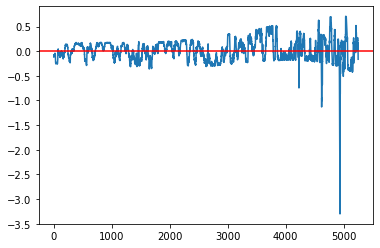

In [16]:
plt.plot(D1(A_hat, x))
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

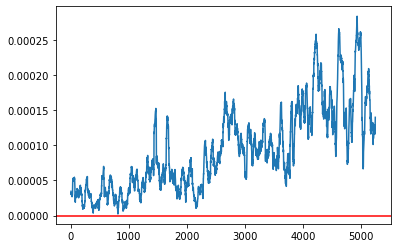

In [17]:
plt.plot(D2(A_hat, x))
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

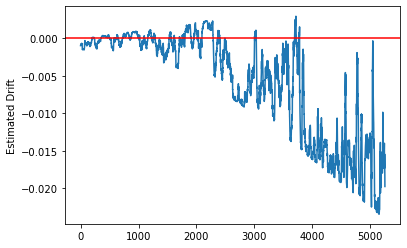

In [18]:
plt.plot(dt*D1(A_hat_cut, x))
plt.ylabel("Estimated Drift")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.show()

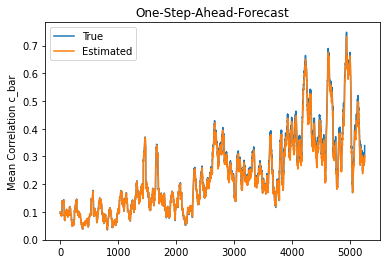

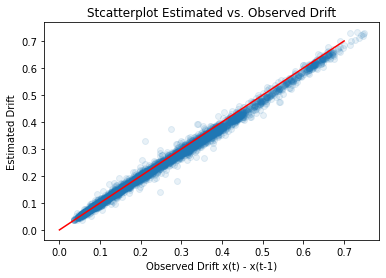

In [19]:
x_hat =  x[:-1,1] + dt*D1(A_hat_cut, x)[:-1]
x_true = x[1:,1]

plt.plot(x_true, label="True")
plt.plot(x_hat,label="Estimated")
plt.legend()
plt.ylabel("Mean Correlation c_bar")
plt.title("One-Step-Ahead-Forecast")
plt.show()

plt.title("Stcatterplot Estimated vs. Observed Drift")
plt.scatter(x_true,x_hat,alpha=0.1)
plt.xlabel("Observed Drift x(t) - x(t-1)")
plt.ylabel("Estimated Drift")
plt.plot((0,0.7), (0,0.7), color="red")
plt.show()

As a comparison: just plot x_hat = x(t-1) vs x(t)

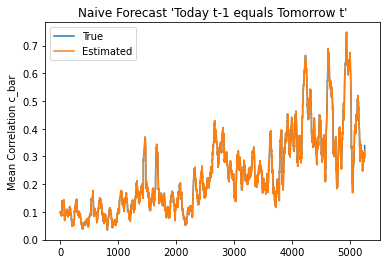

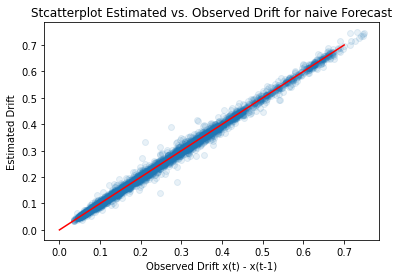

In [20]:
x_hat2 =  x[:-1,1] 
x_true = x[1:,1]

plt.plot(x_true, label="True")
plt.plot(x_hat2,label="Estimated")
plt.legend()
plt.ylabel("Mean Correlation c_bar")
plt.title("Naive Forecast 'Today t-1 equals Tomorrow t'")
plt.show()

plt.title("Stcatterplot Estimated vs. Observed Drift for naive Forecast")
plt.scatter(x_true,x_hat2,alpha=0.1)
plt.xlabel("Observed Drift x(t) - x(t-1)")
plt.ylabel("Estimated Drift")
plt.plot((0,0.7), (0,0.7), color="red")
plt.show()

In [25]:
print(sum(x_hat-x_true)**2.)
print(sum(x_hat2-x_true)**2.)

965.6609496020967
0.05668644704750744


In [21]:
print(sum(dx[:,1]>0)/len(dx[:,1]))
print(np.mean(dx[:,1]))

0.5083809523809524
4.5350315765666074e-05


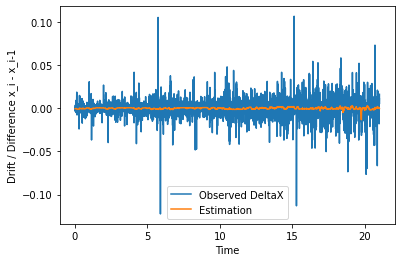

In [22]:
plt.plot(x[1:,0],dx[:,1], label = "Observed DeltaX")
plt.plot(x[1:,0],dt*D1(A_hat, x)[:-1], label="Estimation")
plt.legend()
plt.ylabel("Drift / Difference x_i - x_i-1")
plt.xlabel("Time")
plt.show()

### Check the Noise Sequence

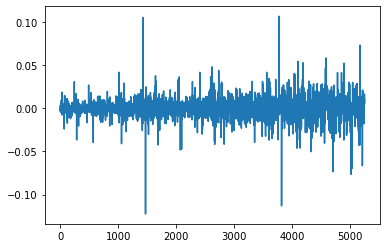

In [23]:
dc_bar = dx[:,1]
plt.plot(dc_bar)
plt.show()